In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy.linalg as la

from sklearn.decomposition import PCA
from pca import pca
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.cluster import KMeans

import statsmodels
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import tukeyhsd

# Carga de datos

In [134]:
data=pd.read_csv("../data/ms_authors.csv",dtype={"age":int,"time":int})
data["citationsProducts"]=data["citations"]/data["products"]
data["pressProducts"]=data["press"]/data["products"]
data["ageProducts"]=data["age"]/data["products"]
data["timeProducts"]=data["time"]/data["products"]
data["productsAge"]=data["products"]/data["age"]
data["productsTime"]=data["products"]/data["time"]
data["std_products"]=(data["products"]-np.mean(data["products"]))/np.std(data["products"])
data["std_citations"]=(data["citations"]-np.mean(data["citations"]))/np.std(data["citations"])
data["std_press"]=(data["press"]-np.mean(data["press"]))/np.std(data["press"])
data["std_citationsProducts"]=(data["citationsProducts"]-np.mean(data["citationsProducts"]))/np.std(data["citationsProducts"])
data["std_pressProducts"]=(data["pressProducts"]-np.mean(data["pressProducts"]))/np.std(data["pressProducts"])
data["std_productsAge"]=(data["productsAge"]-np.mean(data["productsAge"]))/np.std(data["productsAge"])
data["std_productsTime"]=(data["productsTime"]-np.mean(data["productsTime"]))/np.std(data["productsTime"])
data["std_oslevel"]=(data["oslevel"]-np.mean(data["oslevel"]))/np.std(data["oslevel"])
data["std_oscategory"]=(data["oscategory"]-np.mean(data["oscategory"]))/np.std(data["oscategory"])
data=data[data["products"]>1]
data=data[data["citations"]>0]
data

,products,citations,press,age,sex,time,level,category,nlevel,ncategory,...,productsTime,std_products,std_citations,std_press,std_citationsProducts,std_pressProducts,std_productsAge,std_productsTime,std_oslevel,std_oscategory
0,101,94,8,59,M,31,DOCTORADO,TITULAR,3,4,...,3.258065,0.963523,0.713775,0.118732,0.199356,-0.220456,0.767876,0.048045,1.125877,1.278961
1,23,6,2,74,M,49,DOCTORADO,TITULAR,3,4,...,0.469388,-0.291436,-0.450852,-0.238866,-0.596456,-0.216539,-0.394190,-0.471513,-0.313880,-0.156917
2,35,32,2,49,M,12,DOCTORADO,ASOCIADO,3,3,...,2.916667,-0.098365,-0.106758,-0.238866,0.179863,-0.231609,-0.059539,-0.015561,-0.114940,-0.156917
3,5,1,9,55,F,26,DOCTORADO,ASOCIADO,3,3,...,0.192308,-0.581041,-0.517024,0.178332,-0.668774,0.649351,-0.576582,-0.523136,-0.313880,-0.324071
4,120,149,2,68,M,26,DOCTORADO,TITULAR,3,4,...,4.615385,1.269218,1.441668,-0.238866,0.568821,-0.252068,0.811704,0.300927,1.483082,1.684734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,52,108,14,56,M,13,DOCTORADO,ASISTENTE,3,1,...,4.000000,0.175152,0.899057,0.476330,1.561183,-0.124405,0.118195,0.186275,0.204665,-0.324071
250,10,4,5,55,M,17,MAESTRIA,ASISTENTE,2,1,...,0.588235,-0.500595,-0.477321,-0.060067,-0.431156,-0.007758,-0.501180,-0.449370,-0.584946,-0.664480
251,49,34,4,62,F,34,MAESTRIA,TITULAR,2,4,...,1.441176,0.126884,-0.080289,-0.119667,-0.082002,-0.219230,0.003528,-0.290459,-0.313880,0.168423
253,17,9,1,52,F,13,DOCTORADO,ASOCIADO,3,3,...,1.307692,-0.387971,-0.411149,-0.298466,-0.277403,-0.230759,-0.380826,-0.315328,-0.313880,-0.324071


In [11]:
data.to_excel("investigadores_prensa_udea.xlsx")

### Descripción de los datos
Los datos provienen de las dependencias puntaje y recurso humano de la universidad de antioquia. Con ellos realizamos un proceso de búsqueda de la aparición del investigador en medios de comunicación (prensa).
Ignoramos los docentes que no tienen producción científica.

Las variables se describen a continuación:
* products (int): Cantidad de publicaciones
* citations (int): Cantidad de veces que han sido citados todos los productos
* citations/products (float): Cantidad de citas dividido la cantidad de productos
* press (int): cantidad de artículos de prensa en los que ha aparecido el investigador
* age (int): Edad del investigador
* time (int): Años que el investigador ha estado en la universidad
* sex (str): Sexo del investigador
* level (str): Nivel académico
* category (str): Categoría

In [135]:
data.describe()

,products,citations,press,age,time,nlevel,ncategory,oscategory,oslevel,citationsProducts,...,productsTime,std_products,std_citations,std_press,std_citationsProducts,std_pressProducts,std_productsAge,std_productsTime,std_oslevel,std_oscategory
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,...,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,47.511521,47.073733,5.764977,52.211982,17.013825,2.751152,3.000000,3.024095,1.762512,0.887276,...,3.416859,0.102936,0.092734,-0.014475,0.147773,-0.098311,0.099644,0.077630,0.082958,0.073394
std,65.414286,80.057873,12.497224,8.700854,8.791030,0.433345,1.170628,1.258880,0.473779,0.850460,...,5.716896,1.052464,1.059518,0.744831,1.010425,0.454838,1.054423,1.065114,1.061650,1.063954
min,2.000000,1.000000,1.000000,32.000000,2.000000,2.000000,1.000000,1.948882,1.397329,0.041667,...,0.142857,-0.629309,-0.517024,-0.298466,-0.856889,-0.259442,-0.614283,-0.532349,-0.735348,-0.835332
25%,14.000000,4.000000,1.000000,45.000000,11.000000,3.000000,3.000000,2.553812,1.585416,0.333333,...,0.958333,-0.436239,-0.477321,-0.298466,-0.510362,-0.240274,-0.422569,-0.380417,-0.313880,-0.324071
50%,26.000000,16.000000,2.000000,51.000000,16.000000,3.000000,3.000000,2.751590,1.585416,0.648000,...,1.789474,-0.243168,-0.318508,-0.238866,-0.136509,-0.218371,-0.245736,-0.225568,-0.313880,-0.156917
75%,56.000000,54.000000,5.000000,59.000000,21.000000,3.000000,4.000000,2.883843,1.800045,1.117647,...,3.750000,0.239508,0.184399,-0.060067,0.421475,-0.134126,0.238878,0.139697,0.167064,-0.045142
max,481.000000,675.000000,118.000000,79.000000,50.000000,3.000000,4.000000,14.052831,5.416106,5.843750,...,57.375000,7.077425,8.402963,6.674701,6.036519,5.161810,9.366570,10.130561,8.269973,9.394428


# PCA

### Los datos sin modificar

In [136]:
pca_data=data[["products","citations","press","age","time","oslevel","oscategory"]]

In [137]:
np.mean(pca_data)

products      47.511521
citations     47.073733
press          5.764977
age           52.211982
time          17.013825
oslevel        1.762512
oscategory     3.024095
dtype: float64

In [138]:
np.std(pca_data)

products      65.263388
citations     79.873195
press         12.468396
age            8.680783
time           8.770751
oslevel        0.472686
oscategory     1.255976
dtype: float64

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [7] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


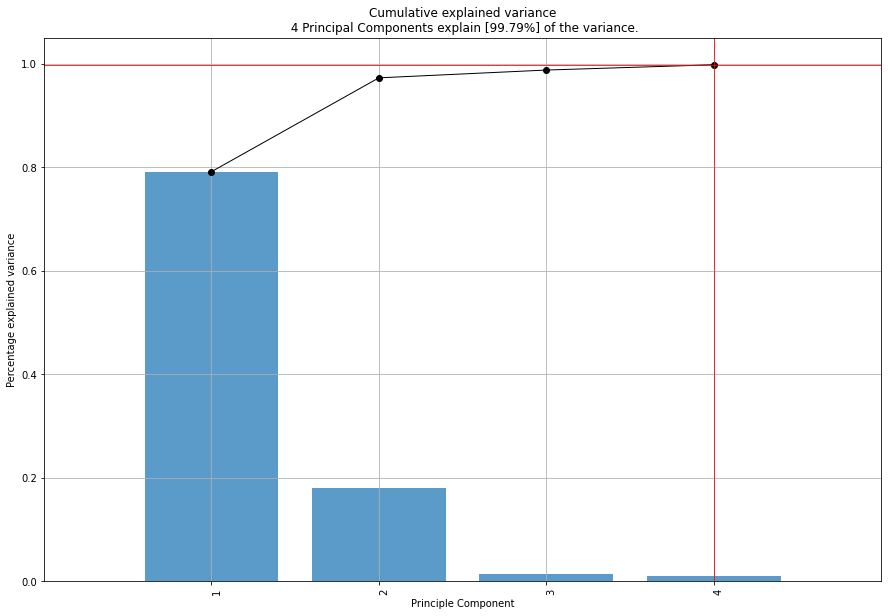

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 432x288 with 0 Axes>

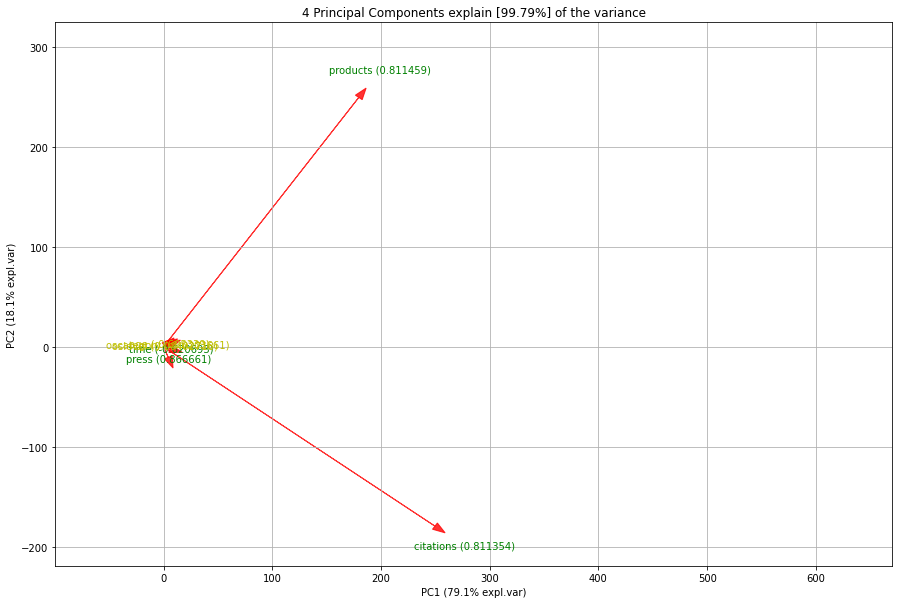

[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


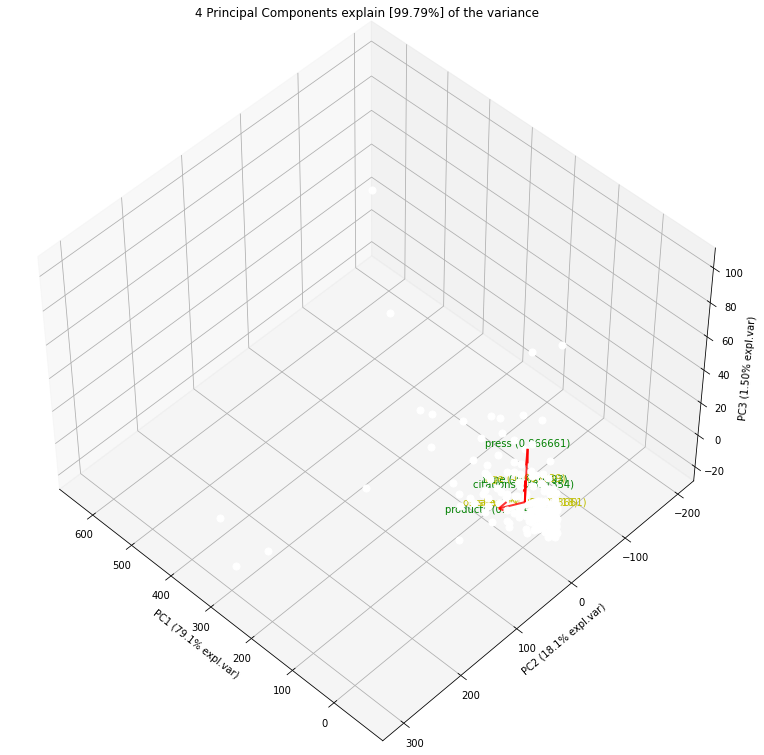

In [139]:
model=pca(n_components=4)
results=model.fit_transform(pca_data)
fig, ax = model.plot()
fig, ax = model.biplot(n_feat=7,legend=False,label=False,cmap=None)
fig, ax = model.biplot3d(n_feat=7,legend=False,label=False,cmap=None)

In [140]:
model.results

{'loadings':      products  citations     press       age      time   oslevel  oscategory
 PC1  0.583728   0.811354  0.014157  0.016086  0.019714  0.004027    0.010142
 PC2  0.811459  -0.583286 -0.034244  0.006858 -0.006290  0.003674    0.006253
 PC3  0.009293  -0.037389  0.866661  0.357805  0.345455  0.001208    0.007028
 PC4  0.022993   0.002131  0.497342 -0.605339 -0.620693 -0.002681   -0.020366,
 'PC':             PC1        PC2        PC3        PC4
 0     69.729422  15.924958   7.950489 -10.379038
 1    -46.709090   4.142413  16.888482 -35.560315
 2    -19.740385  -1.223882  -5.698965   2.869890
 3    -61.934933  -7.773991   8.229644  -6.722039
 4    125.411477  -0.435804   2.367222 -15.163822
 ..          ...        ...        ...        ...
 249   52.146638 -32.128721   4.866243   4.536396
 250  -56.820863  -5.275924   1.585227  -2.995285
 251   -9.270792   8.854330   8.343742 -17.341517
 253  -48.857170  -2.367611  -4.455571  -0.522784
 254   21.363311  19.476858   1.684877   

### Con las variables relativas

In [141]:
pca_data=data[["citationsProducts","pressProducts","productsAge","productsTime","oslevel","oscategory"]]

In [142]:
np.mean(pca_data)

citationsProducts    0.887276
pressProducts        0.320855
productsAge          0.906206
productsTime         3.416859
oslevel              1.762512
oscategory           3.024095
dtype: float64

In [143]:
np.std(pca_data)

citationsProducts    0.848498
pressProducts        0.897758
productsAge          1.268341
productsTime         5.703708
oslevel              0.472686
oscategory           1.255976
dtype: float64

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


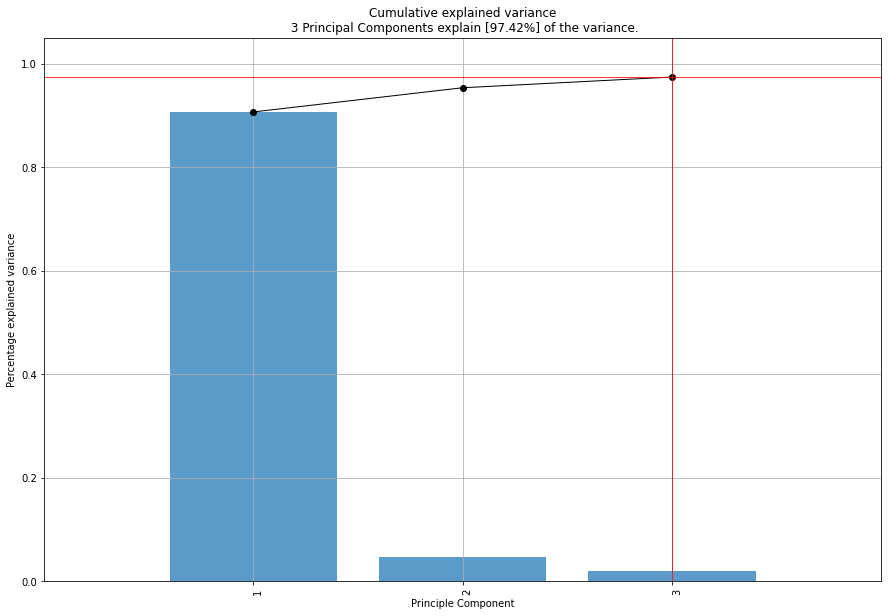

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 432x288 with 0 Axes>

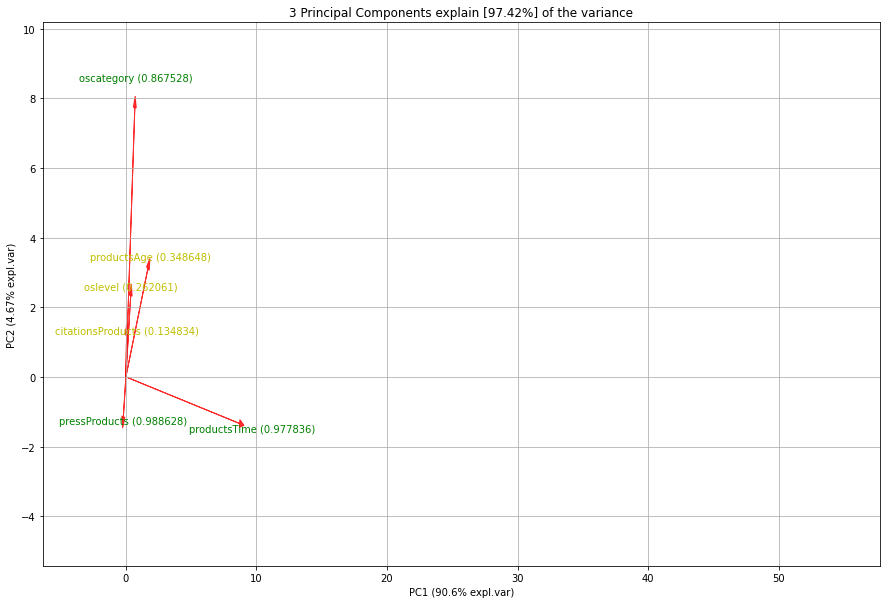

In [144]:
model=pca(n_components=3)
results=model.fit_transform(pca_data)
#fig, ax = model.scatter()
fig, ax = model.plot()
fig, ax = model.biplot(n_feat=6,legend=False,label=False,cmap=None)

In [145]:
model.results

{'loadings':      citationsProducts  pressProducts  productsAge  productsTime   oslevel  \
 PC1           0.006017      -0.021509     0.189024      0.977836  0.041427   
 PC2           0.134834      -0.128102     0.348648     -0.150243  0.262061   
 PC3          -0.057503       0.988628     0.043305      0.002163  0.039789   
 
      oscategory  
 PC1    0.076755  
 PC2    0.867528  
 PC3    0.125873  ,
 'PC':           PC1       PC2       PC3
 0    0.131241  1.701003 -0.008782
 1   -3.021678 -0.102060 -0.268725
 2   -0.544123 -0.213888 -0.309475
 3   -3.386577 -0.536329  1.393321
 4    1.515137  2.023727 -0.016493
 ..        ...       ...       ...
 249  0.548866 -0.306548 -0.174250
 250 -2.989002 -0.751740  0.045885
 251 -1.948523  0.312133 -0.227566
 253 -2.211868 -0.354158 -0.334364
 254  2.495767 -0.301355 -0.152746
 
 [217 rows x 3 columns],
 'explained_var': array([0.90684519, 0.95356619, 0.97425295]),
 'variance_ratio': array([0.90684519, 0.046721  , 0.02068676]),
 'model': PCA

### Con las variables normalizadas

In [146]:
pca_data=data[["std_citationsProducts","std_pressProducts","std_productsAge","std_productsTime","std_oslevel","std_oscategory"]]

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


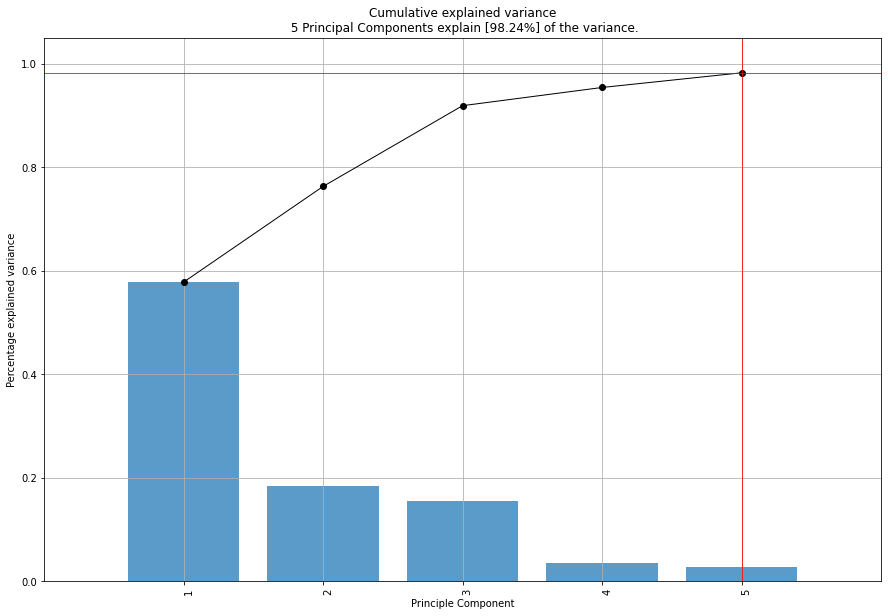

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 432x288 with 0 Axes>

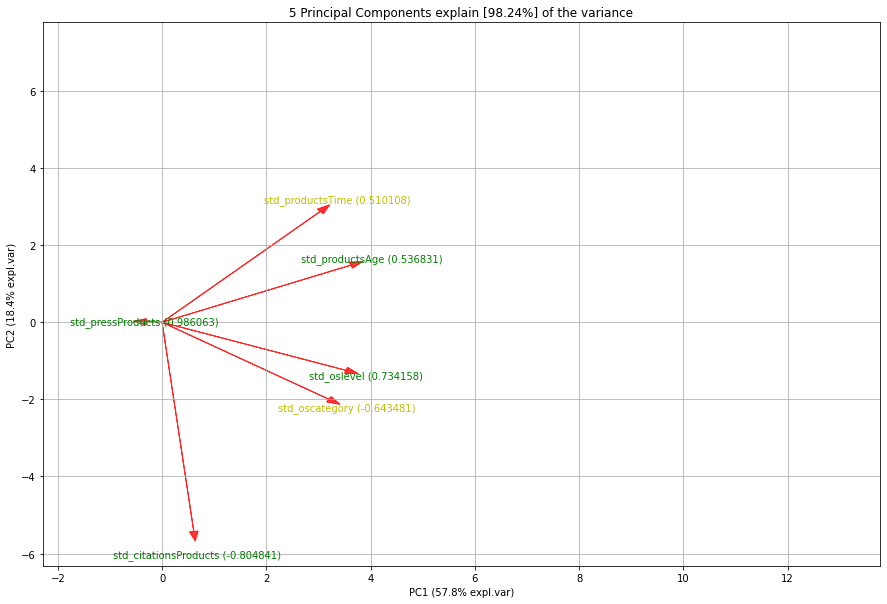

In [147]:
model=pca(n_components=5)
results=model.fit_transform(pca_data)
#fig, ax = model.scatter()
fig, ax = model.plot()
fig, ax = model.biplot(n_feat=6,legend=False,label=False,cmap=None)

In [148]:
model.results

{'loadings':      std_citationsProducts  std_pressProducts  std_productsAge  \
 PC1               0.090183          -0.045099         0.536831   
 PC2              -0.804841           0.001935         0.219696   
 PC3               0.586305          -0.005017         0.220468   
 PC4               0.005893           0.986063         0.006400   
 PC5              -0.017496          -0.159277        -0.039308   
 
      std_productsTime  std_oslevel  std_oscategory  
 PC1          0.450242     0.523183        0.474560  
 PC2          0.426620    -0.184999       -0.296197  
 PC3          0.510108    -0.314598       -0.498430  
 PC4          0.008902     0.144190       -0.082060  
 PC5         -0.140443     0.734158       -0.643481  ,
 'PC':           PC1       PC2       PC3       PC4       PC5
 0    1.473319 -0.457590 -0.765902 -0.064676 -0.013651
 1   -0.891053  0.397620 -0.585111 -0.167337 -0.014756
 2   -0.331340  0.004014  0.113903 -0.142736  0.042927
 3   -1.137106  0.444918 -0.61508

### Con las variables sugeridas por el profesor

In [149]:
pca_data=data[["std_citationsProducts","std_productsTime","std_productsAge","std_oslevel","std_oscategory"]]

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


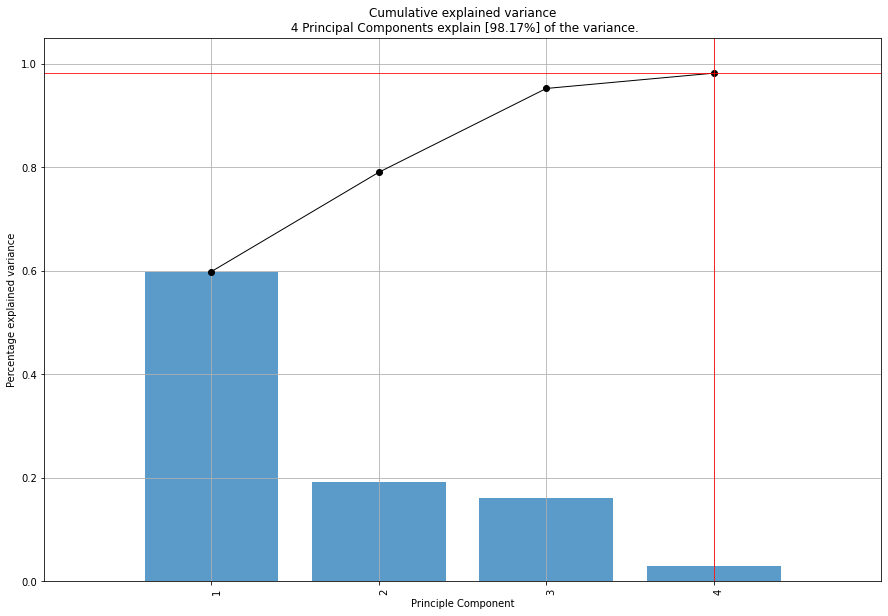

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 432x288 with 0 Axes>

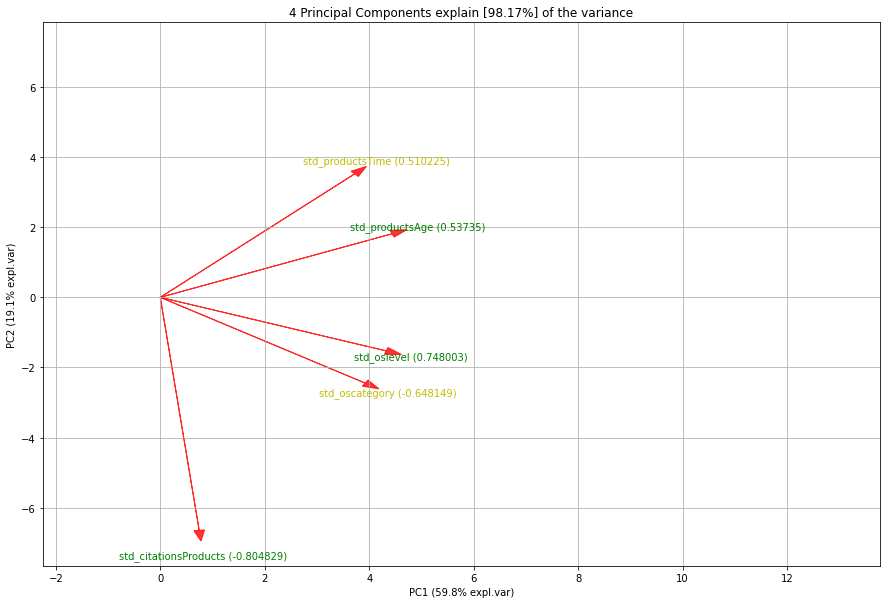

In [151]:
model=pca(n_components=4)
results=model.fit_transform(pca_data)
#fig, ax = model.scatter()
fig, ax = model.plot()
fig, ax = model.biplot(n_feat=5,legend=False,label=False,cmap=None)

In [152]:
model.results

{'loadings':      std_citationsProducts  std_productsTime  std_productsAge  std_oslevel  \
 PC1               0.090208          0.450682         0.537350     0.523801   
 PC2              -0.804829          0.426587         0.219643    -0.185086   
 PC3               0.586379          0.510225         0.220607    -0.314406   
 PC4              -0.016372         -0.136387        -0.039047     0.748003   
 
      std_oscategory  
 PC1        0.475011  
 PC2       -0.296267  
 PC3       -0.498309  
 PC4       -0.648149  ,
 'PC':           PC1       PC2       PC3       PC4
 0    1.469334 -0.457563 -0.766076 -0.024183
 1   -0.897251  0.397935 -0.585995 -0.041198
 2   -0.337701  0.004317  0.113138  0.019647
 3   -1.104448  0.443579 -0.611683  0.082489
 4    2.020034 -0.823747 -0.725242 -0.062245
 ..        ...       ...       ...       ...
 249  0.061383 -0.991903  1.048114  0.309970
 250 -1.312934  0.451388 -0.163224  0.083473
 251 -0.400991  0.052092 -0.266333 -0.300713
 253 -0.870299  0.2

### Los definitivos

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


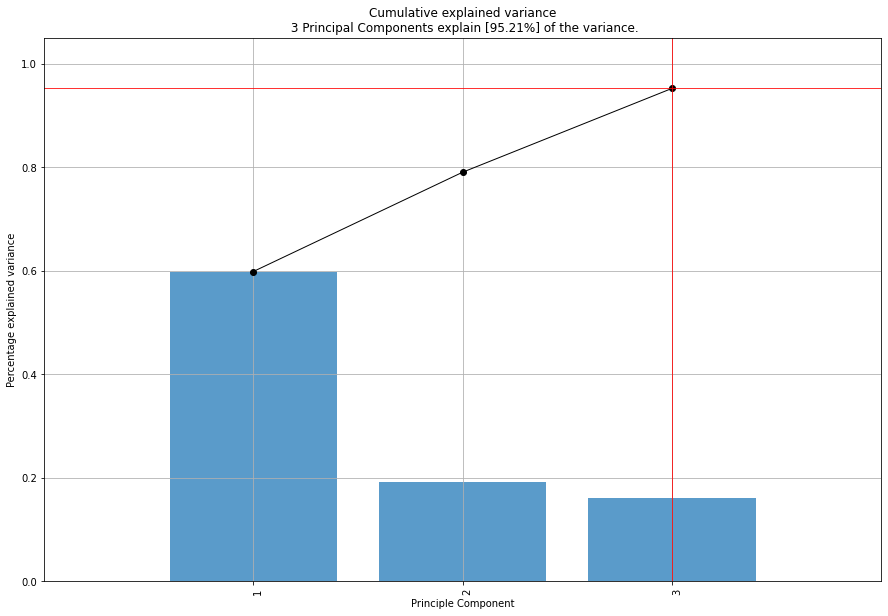

[pca] >Plot PC1 vs PC2 with loadings.


<Figure size 432x288 with 0 Axes>

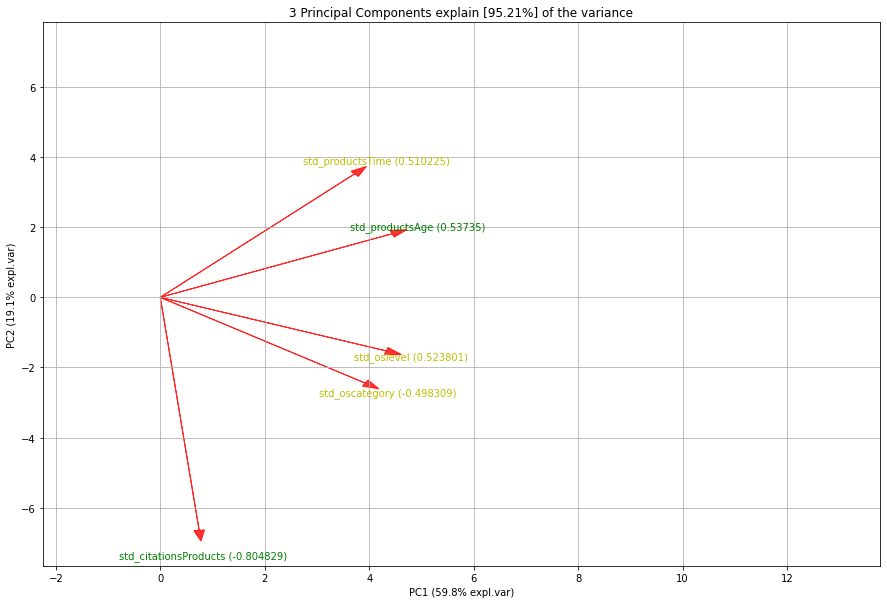

{'loadings':      std_productsTime  std_productsAge  std_citationsProducts  std_oslevel  \
 PC1          0.450682         0.537350               0.090208     0.523801   
 PC2          0.426587         0.219643              -0.804829    -0.185086   
 PC3          0.510225         0.220607               0.586379    -0.314406   
 
      std_oscategory  
 PC1        0.475011  
 PC2       -0.296267  
 PC3       -0.498309  ,
 'PC':           PC1       PC2       PC3
 0    1.469334 -0.457563 -0.766076
 1   -0.897251  0.397935 -0.585995
 2   -0.337701  0.004317  0.113138
 3   -1.104448  0.443579 -0.611683
 4    2.020034 -0.823747 -0.725242
 ..        ...       ...       ...
 249  0.061383 -0.991903  1.048114
 250 -1.312934  0.451388 -0.163224
 251 -0.400991  0.052092 -0.266333
 253 -0.870299  0.260236 -0.232978
 254  0.676107  0.460218  0.157162
 
 [217 rows x 3 columns],
 'explained_var': array([0.59859051, 0.79036629, 0.95219312]),
 'variance_ratio': array([0.59859051, 0.19177578, 0.16182684]

In [155]:
#prensa va solita
# Hay que buscar uno de productsAge y productsTime
pca_data=data[["std_productsTime","std_productsAge","std_citationsProducts","std_oslevel","std_oscategory"]]
model=pca(n_components=3)
results=model.fit_transform(pca_data)
fig, ax = model.plot()
fig, ax = model.biplot(n_feat=5,legend=False,label=False,cmap=None)
model.results

In [156]:
data["PCA_time"]=model.results["PC"]["PC3"]
data["PCA_production"]=model.results["PC"]["PC2"]
data["PCA_classification"]=model.results["PC"]["PC1"]

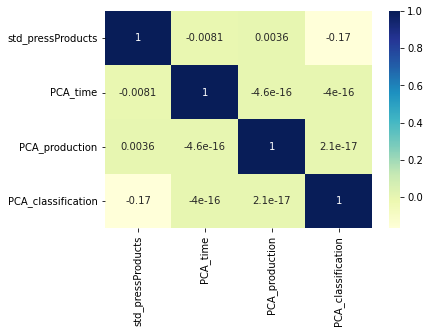

In [157]:
sns.heatmap(data[["std_pressProducts","PCA_time","PCA_production","PCA_classification"]].corr(), cmap="YlGnBu", annot=True);

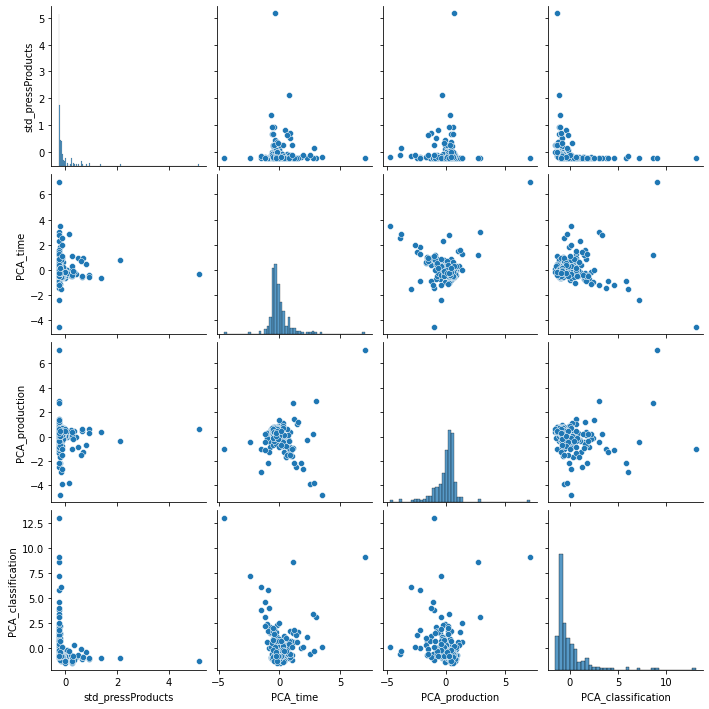

In [159]:
sns.pairplot(data[["std_pressProducts","PCA_time","PCA_production","PCA_classification"]],kind="scatter");

## Análisis factorial

In [ ]:
#Se debe hacer con variables normalizadas

In [187]:
factor_data=data[["citationsProducts","pressProducts","productsAge","productsTime","oslevel","oscategory"]]
factor_data=pd.DataFrame()
factor_data["citationsProducts"]=(data["citationsProducts"]-np.mean(data["citationsProducts"]))/np.std(data["citationsProducts"])
factor_data["pressProducts"]=(data["pressProducts"]-np.mean(data["pressProducts"]))/np.std(data["pressProducts"])
factor_data["productsAge"]=(data["productsAge"]-np.mean(data["productsAge"]))/np.std(data["productsAge"])
factor_data["productsTime"]=(data["productsTime"]-np.mean(data["productsTime"]))/np.std(data["productsTime"])
factor_data["oslevel"]=(data["oslevel"]-np.mean(data["oslevel"]))/np.std(data["oslevel"])
factor_data["oscategory"]=(data["oscategory"]-np.mean(data["oscategory"]))/np.std(data["oscategory"])

In [195]:
#Evaluates the null hypothesis that the correlation amtrix is an identity matrix.
#If it is, then it makes little sense in performing the factor analysis
#since it would indicate that we have zero pairwise correlations between variables (values of 0 in the off diagonal)
chi_square_value,p_value=calculate_bartlett_sphericity(factor_data)
print("chi^2: {}, p-value: {}".format(chi_square_value,p_value))

chi^2: 750.019051125519, p-value: 4.0008054001238655e-150


In [196]:
#Measures the likely utility for conducting a factor analysis
#in the sense of providing an estimate of the proportion of variance
#in variables that might be  due to underlying factors (Denis,2020)
kmo_all,kmo_model=calculate_kmo(factor_data)
kmo_model #values around 0.7 are preferrable

0.6612271491159899

In [209]:
fa = FactorAnalyzer();
fa.set_params(n_factors=4,method='minres',rotation=None);
fa.fit(factor_data);

In [201]:
fa.loadings_

array([[ 0.11688559,  0.08734092,  0.05602955, -0.13499648],
       [-0.17364823,  0.00240796,  0.05511325,  0.13423876],
       [ 0.91745414, -0.27524003, -0.01006677, -0.00405926],
       [ 0.7568973 , -0.56982715, -0.02273858,  0.01103696],
       [ 0.88223338,  0.31552134,  0.16840664,  0.02044311],
       [ 0.79861698,  0.49543965, -0.14914048,  0.02056582]])

In [210]:
fa.get_eigenvalues()

(array([2.98515311, 1.01286919, 0.95747647, 0.81003856, 0.14455325,
        0.08990941]),
 array([ 2.87455677e+00,  7.53108682e-01,  5.73988204e-02,  3.72228578e-02,
         1.53314572e-06, -1.72130412e-06]))

In [211]:
#extraer varianza específica o la varianza no explicada por comunalidades

In [212]:
fa.get_communalities()

array([0.04265404, 0.05121702, 0.917597  , 0.89823536, 0.90666818,
       0.90591536])

In [213]:
var=1-np.sum(fa.get_communalities()[:2]**2)
var

0.9955574498963716

In [26]:
fa_varimax = FactorAnalyzer(rotation='varimax')
fa_varimax.fit(factor_data)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [27]:
fa_varimax.get_communalities()

array([0.12709512, 0.08513241, 0.88112272, 0.99190966, 0.88335484,
       0.8171734 ])

In [28]:
var=1-np.sum(fa.get_communalities()[:2]**2)
var

0.9981098202393538

# Clustering

### Con los datos pelados

In [161]:
data_clustering=data[["citationsProducts","pressProducts","productsAge","productsTime",]]

In [162]:
kmeans=KMeans(n_clusters=2,max_iter=1000,tol=1e-6)
kmeans.fit(data_clustering)
kprediction=kmeans.predict(data_clustering)

In [163]:
centroids = kmeans.cluster_centers_
centroids

array([[7.56862932e-01, 5.50209172e-01, 6.49791217e-01, 2.36851752e+00],
       [7.47428100e-01, 1.68897637e-02, 6.29732895e+00, 3.34183333e+01]])

In [164]:
centroids[0,[0,2]],centroids[1,[0,2]]

(array([0.75686293, 0.64979122]), array([0.7474281 , 6.29732895]))

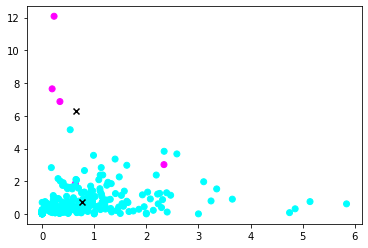

In [166]:
plt.scatter(data["citationsProducts"],data["productsAge"], c = kprediction, cmap = 'cool')
plt.scatter(centroids[0,[0,2]],centroids[1,[0,2]],c="black",marker="x")

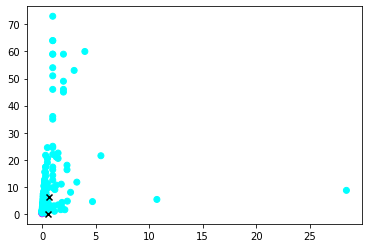

In [169]:
plt.scatter(data["pressProducts"],data["ageProducts"], c = kprediction, cmap = 'cool')
plt.scatter(centroids[0,[1,2]],centroids[1,[1,2]],c="black",marker="x")

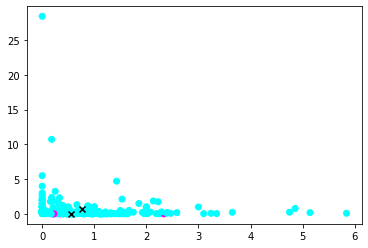

In [171]:
plt.scatter(data["citationsProducts"],data["pressProducts"], c = kprediction, cmap = 'cool')
plt.scatter(centroids[0,[0,1]],centroids[1,[0,1]],c="black",marker="x")

### With results from PCA

In [184]:
data_clustering=model.results["PC"][["PC1","PC2"]]
kmeans=KMeans(n_clusters=3,max_iter=1000,tol=1e-6)
kmeans.fit(data_clustering)
kprediction=kmeans.predict(data_clustering)

In [185]:
centroids= kmeans.cluster_centers_
centroids

array([[ 4.40181432, -0.2864881 ],
       [-1.6044624 ,  0.03876403],
       [30.98838275,  1.01668505]])

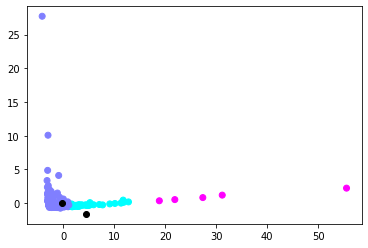

In [186]:
plt.scatter(data_clustering["PC1"],data_clustering["PC2"], c = kprediction, cmap = 'cool')
plt.scatter(centroids[0,:],centroids[1,:],c="black")

# Transformaciones de potencia

In [171]:
result=stats.boxcox(data["products"],alpha=None)
sw=stats.shapiro(result[0])
print("lambda: {},statistic: {}, p-value: {}".format(result[1],sw[0],sw[1]))
data["products_norm"]=result[0]

lambda: -0.012305200319834274,statistic: 0.9922577738761902, p-value: 0.30946001410484314


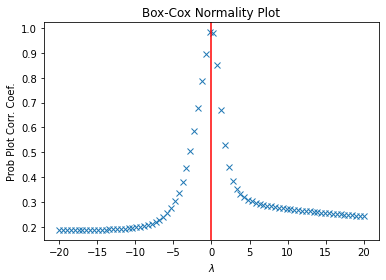

In [172]:
fig = plt.figure();
ax = fig.add_subplot(111);
stats.boxcox_normplot(data["products"],-20,20,plot=ax);
_, maxlog = stats.boxcox(data["products"])
ax.axvline(maxlog, color='r')

In [174]:
result=stats.boxcox(data["citations"],alpha=None)
sw=stats.shapiro(result[0])
print("lambda: {}, statistic: {}, p-value: {}".format(result[1],sw[0],sw[1]))
data["citations_norm"]=result[0]

lambda: -0.0007694599579139317, statistic: 0.9747174382209778, p-value: 0.0006157647003419697


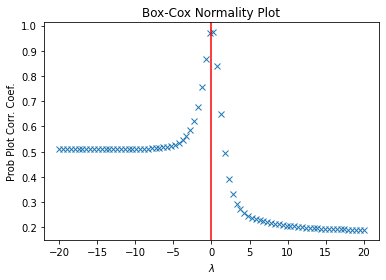

In [175]:
fig = plt.figure();
ax = fig.add_subplot(111);
stats.boxcox_normplot(data["citations"],-20,20,plot=ax);
_, maxlog = stats.boxcox(data["citations"])
ax.axvline(maxlog, color='r')

In [162]:
for l in np.linspace(-1.9,2,40):
    result=stats.boxcox(data["citations"],lmbda=l)
    sw=stats.shapiro(result)
    if np.abs(sw[1]-0.05)<0.05:
        print("l:{}\n\tstatistic: {}, p-value: {}".format(l,sw[0],sw[1]))

l:-0.7
	statistic: 0.7746566534042358, p-value: 5.88972448472457e-17
l:-0.6000000000000001
	statistic: 0.8150303363800049, p-value: 2.4552317237679436e-15
l:-0.5
	statistic: 0.8544150590896606, p-value: 1.719068680808289e-13
l:-0.40000000000000013
	statistic: 0.8911818265914917, p-value: 2.0074060469443822e-11
l:-0.30000000000000004
	statistic: 0.9234674572944641, p-value: 3.511268165112824e-09
l:-0.19999999999999996
	statistic: 0.949325442314148, p-value: 6.562175940416637e-07
l:-0.10000000000000009
	statistic: 0.9669185876846313, p-value: 5.842990867677145e-05
l:0.0
	statistic: 0.9747368693351746, p-value: 0.0006195970345288515
l:0.09999999999999987
	statistic: 0.9717589020729065, p-value: 0.00024410421610809863
l:0.19999999999999973
	statistic: 0.9575812220573425, p-value: 4.777382400789065e-06
l:0.2999999999999998
	statistic: 0.9324445724487305, p-value: 1.8761044273674088e-08
l:0.3999999999999999
	statistic: 0.8972041010856628, p-value: 4.8358091836453454e-11
l:0.5
	statistic: 0.8

# MANOVA

In [207]:
data_manova=data[["category","level","products_norm","citations_norm"]]

In [208]:
manova = MANOVA.from_formula("products_norm + citations_norm ~ C(category) + C(level)",data=data_manova)
print(manova.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.3728 2.0000 211.0000 177.4882 0.0000
         Pillai's trace 0.6272 2.0000 211.0000 177.4882 0.0000
 Hotelling-Lawley trace 1.6824 2.0000 211.0000 177.4882 0.0000
    Roy's greatest root 1.6824 2.0000 211.0000 177.4882 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
       C(category)       Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.8651 6.0000 422.0000  5.2850 0.0000
          Pillai's trace 0.1368 6.0000 424.0000  5.1882 0.0000
  Hotelling

In [185]:
manova = MANOVA.from_formula("products_norm + citations_norm ~ C(category) + C(category):C(level)",data=data_manova)
print(manova.mv_test())

ValueError: Covariance of x singular!